In [23]:
import pandas as pd
df = pd.read_csv('train.csv')


In [24]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Check if stopwords are accessible directly
print(stopwords.words('english'))


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [25]:
import spacy

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

def clean_text_spacy(text):
    if not isinstance(text, str):  # Ensure it's a string
        return ''
    doc = nlp(text)
    return ' '.join([token.text for token in doc if not token.is_stop and not token.is_punct])

# Select the first 400 rows
df_subset = df.head(10000).copy()  # Use .copy() to avoid setting on a slice

# Handle missing values and clean the text using .loc
df_subset.loc[:, 'text'] = df_subset['text'].fillna('')  # Replace NaN with an empty string
df_subset.loc[:, 'cleaned_text'] = df_subset['text'].apply(clean_text_spacy)


In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Tokenize the cleaned text
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df_subset['cleaned_text'])

# Convert text to sequences of integers
X = tokenizer.texts_to_sequences(df_subset['cleaned_text'])

# Pad sequences to ensure they all have the same length
X_pad = pad_sequences(X, padding='post', maxlen=100)

# Label encoding (assuming label is binary 0 or 1)
y = df_subset['label']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)


In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential()

# Embedding layer to convert tokens to dense vectors
model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))

# LSTM layer to capture sequential information
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))

# Dense layer for classification (binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary of the model
model.summary()


c:\projects ml\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), verbose=2)


Epoch 1/5
125/125 - 12s - 93ms/step - accuracy: 0.8241 - loss: 0.4235 - val_accuracy: 0.8630 - val_loss: 0.3744
Epoch 2/5
125/125 - 9s - 75ms/step - accuracy: 0.9277 - loss: 0.2182 - val_accuracy: 0.8790 - val_loss: 0.3421
Epoch 3/5
125/125 - 10s - 77ms/step - accuracy: 0.9595 - loss: 0.1286 - val_accuracy: 0.9060 - val_loss: 0.2357
Epoch 4/5
125/125 - 10s - 76ms/step - accuracy: 0.9778 - loss: 0.0831 - val_accuracy: 0.9065 - val_loss: 0.2484
Epoch 5/5
125/125 - 9s - 76ms/step - accuracy: 0.9818 - loss: 0.0625 - val_accuracy: 0.9110 - val_loss: 0.2908


In [29]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9132 - loss: 0.2997
Test Loss: 0.290848970413208
Test Accuracy: 0.9110000133514404


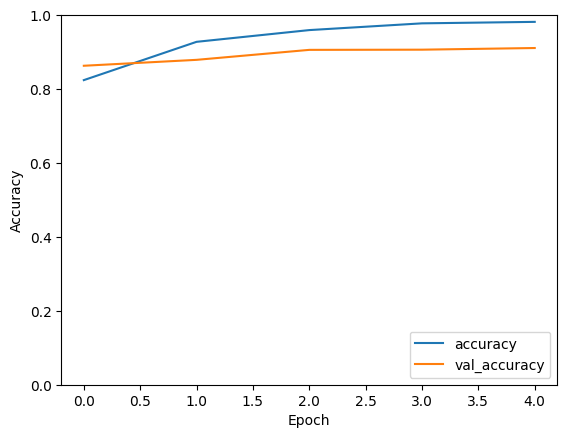

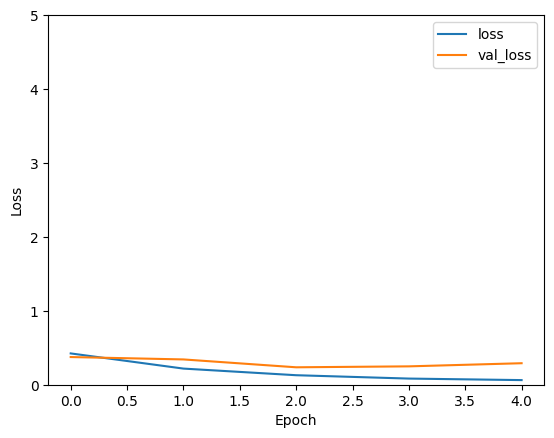

In [30]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 5])
plt.legend(loc='upper right')
plt.show()


In [31]:
new_text = ["Breaking news: Scientists discover a cure for cancer!"]
new_text_seq = tokenizer.texts_to_sequences(new_text)
new_text_pad = pad_sequences(new_text_seq, padding='post', maxlen=100)

prediction = model.predict(new_text_pad)
print(f"Prediction: {'Fake' if prediction[0] < 0.5 else 'Real'}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
Prediction: Real
